In [8]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import io, os, sys, types
import networkx as nx
import numpy as np
import pandas as pd
from tensorflow import keras
import json
import re
from collections import Counter
from IPython.display import Image, HTML, display

import stellargraph as sg
from IPython.display import display, HTML
from stellargraph import StellarGraph
from stellargraph.data import BiasedRandomWalk
from stellargraph.data import UnsupervisedSampler
from stellargraph.data import BiasedRandomWalk
from stellargraph.mapper import Node2VecLinkGenerator, Node2VecNodeGenerator
from stellargraph.layer import Node2Vec, link_classification
import time
from sklearn.metrics.pairwise import cosine_similarity

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Listing 6-7. Creating a StellarGraph-Specific Graph

In [83]:
from stellargraph import IndexedArray
import pandas as pd

nodes = IndexedArray(np.array([[1,2],[2,1], [5,4],[4,5]]),index=['a','b','c','d'])
#print("nodes",nodes)
edges = pd.DataFrame({"source":["a","b","c","d","a"],"target":["b","c","d","a","c"]})
GS_example = StellarGraph(nodes,edges)
print("Graph info", GS_example.info())
print(f"Graph directed:{GS_example.is_directed()}")
print(f"Nodes :{GS_example.nodes()}")
print(f"Node features :{GS_example.node_features()}")



Graph info StellarGraph: Undirected multigraph
 Nodes: 4, Edges: 5

 Node types:
  default: [4]
    Features: int64 vector, length 2
    Edge types: default-default->default

 Edge types:
    default-default->default: [5]
        Weights: all 1 (default)
        Features: none
Graph directed:False
Nodes :Index(['a', 'b', 'c', 'd'], dtype='object')
Node features :[[1 2]
 [2 1]
 [5 4]
 [4 5]]


# Listing 6-8. Node2Vec Implementation on Cora Dataset for Node Embedding creation

link_classification: using 'dot' method to combine node embeddings into edge embeddings
Epoch 1/2
39760/39760 [==============================] - 140s 4ms/step - loss: 0.3017 - binary_accuracy: 0.8497
Epoch 2/2
50/50 [==============================] - 0s 3ms/step
Shape of the node Embeddings : (2485, 128)
Length of embedded vectors: 128
Total embedded vectors: 2485


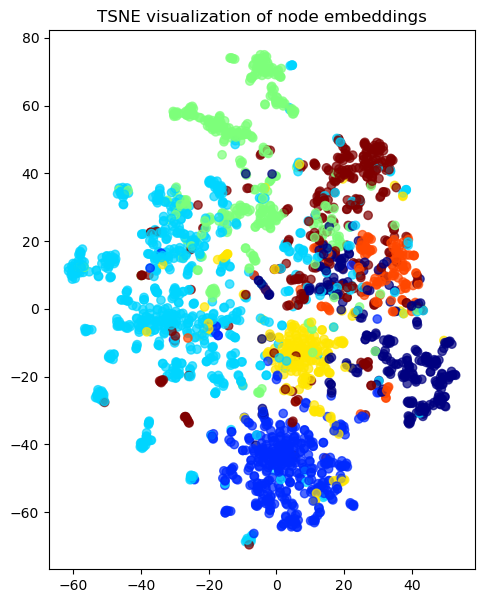

In [48]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import io, os, sys, types
import networkx as nx
import numpy as np
import pandas as pd
from tensorflow import keras
import json
import re
from collections import Counter
from IPython.display import Image, HTML, display

import stellargraph as sg
from IPython.display import display, HTML
from stellargraph import StellarGraph
from stellargraph.data import BiasedRandomWalk
from stellargraph.data import UnsupervisedSampler
from stellargraph.data import BiasedRandomWalk
from stellargraph.mapper import Node2VecLinkGenerator, Node2VecNodeGenerator
from stellargraph.layer import Node2Vec, link_classification
import time
from sklearn.metrics.pairwise import cosine_similarity

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

def load_cora_dataset():
    dataset = sg.datasets.Cora()
    display(HTML(dataset.description))
    GS, node_subjects = dataset.load(largest_connected_component_only=True)
    # GS contains the Stellar Graph
    # node_subjects contains the node_features indexed by the node ids
    return GS, node_subjects

def random_walker(graph_s,num_walks_per_node,walk_length,p=0.5,q=2.0):
    walker = BiasedRandomWalk(
        graph_s,
        n=num_walks_per_node,
        length=walk_length,
        p=p,  # defines probability, 1/p, of returning to source node
        q=q,  # defines probability, 1/q, for moving to a node away from the source node
    )
    return walker 

def create_unsupervised_sampler(graph_s,walker):
    nodes=list(graph_s.nodes())
    unsupervised_sampler = UnsupervisedSampler(graph_s, nodes=nodes, walker=walker)
    return unsupervised_sampler


def train(batch_size=50,epochs=2,num_walks_per_node=100,walk_length=5,p=0.5,q=2.0,emb_dim=128,lr=1e-3):
    
    GS, node_subjects = load_cora_dataset()
   
    # Create a random walker sampler 
    walker = random_walker(graph_s=GS,num_walks_per_node=num_walks_per_node, \
                                walk_length=walk_length,p=p,q=q)
    
    unsupervised_sampler = create_unsupervised_sampler(graph_s=GS,walker=walker)
    
    
    # Create a batch generator
    generator = Node2VecLinkGenerator(GS, batch_size)
    
    # Define the Node2Vec model    
    node2vec = Node2Vec(emb_dim, generator=generator)
    x_inp, x_out = node2vec.in_out_tensors()
    # link_classification is the output layer that maximizes the dot product of the similar nodes
    prediction = link_classification(
    output_dim=1, output_act="sigmoid", edge_embedding_method="dot"
    )(x_out)
    model = keras.Model(inputs=x_inp, outputs=prediction)

    # Compile Model
    model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=lr),
    loss=keras.losses.binary_crossentropy,
    metrics=[keras.metrics.binary_accuracy],
    )
    
    # Train the model
    history = model.fit(
    generator.flow(unsupervised_sampler),
    epochs=epochs,
    verbose=1,
    use_multiprocessing=False,
    workers=4,
    shuffle=True,
    )
    
    # Predict the embedding
    x_inp_src = x_inp[0]
    x_out_src = x_out[0]
    embedding_model = keras.Model(inputs=x_inp_src, outputs=x_out_src)
    
    node_gen = Node2VecNodeGenerator(GS, batch_size).flow(node_subjects.index)
    node_embeddings = embedding_model.predict(node_gen, workers=4, verbose=1)
    print(f"Shape of the node Embeddings : {node_embeddings.shape}")
    print('Length of embedded vectors:',len(node_embeddings[0]))
    print('Total embedded vectors:', len(node_embeddings))
    plot_embeddings(node_embeddings,node_subjects)
    
    
def plot_embeddings(node_embeddings,node_subjects,n_components=2):
    
    transform = TSNE  
    trans = transform(n_components=2)
    node_embeddings_2d = trans.fit_transform(node_embeddings)
    # draw the embedding points, coloring them by the target label (paper subject)
    alpha = 0.7
    label_map = {l: i for i, l in enumerate(np.unique(node_subjects))}
    node_colours = [label_map[target] for target in node_subjects]

    plt.figure(figsize=(7, 7))
    plt.axes().set(aspect="equal")
    plt.scatter(
        node_embeddings_2d[:, 0],
        node_embeddings_2d[:, 1],
        c=node_colours,
        cmap="jet",
        alpha=alpha,
    )
    plt.title("{} visualization of node embeddings".format(transform.__name__))
    plt.show()
    

train()

    
    

# Listing 6-9. Graph Classification Using GCN

In [77]:
import pandas as pd
import numpy as np

from stellargraph.mapper import PaddedGraphGenerator
from stellargraph.layer import GCNSupervisedGraphClassification
from stellargraph import StellarGraph
from stellargraph.layer import DeepGraphCNN

from stellargraph import datasets

from sklearn.model_selection import train_test_split
from IPython.display import display, HTML

from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Flatten
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import matplotlib.pyplot as plt

#Import the data
def load_data(verbose=True):
    dataset = datasets.MUTAG()
    display(HTML(dataset.description))
    graphs, graph_labels = dataset.load()
    print(f"Number of graphs: :{len(graphs)}")
    print(f"The class distribution of the graphs:\n {graph_labels.value_counts().to_frame()}\n")
    if verbose:
        print(f"Graph 0 info",graphs[0].info())
        print("Graph 0 node features",graphs[0].node_features())
    return graphs, graph_labels


def GCN_model(generator,lr=0.005):
    gc_model = GCNSupervisedGraphClassification(
        layer_sizes=[64, 64],
        activations=["relu", "relu"],
        generator=generator,
        dropout=0.5,
    )
    x_inp, x_out = gc_model.in_out_tensors()
    predictions = Dense(units=32, activation="relu")(x_out)
    predictions = Dense(units=16, activation="relu")(predictions)
    predictions = Dense(units=1, activation="sigmoid")(predictions)

    # Let's create the Keras model and prepare it for training
    model = Model(inputs=x_inp, outputs=predictions)
    model.compile(optimizer=Adam(lr), loss=binary_crossentropy, metrics=["acc"])
    return model

def train(epochs=10,lr=0.005,batch_size=8):
    # Load the graphs
    graphs, graph_labels = load_data(verbose=False)

    # Convert the graph labels to 0 and 1 instead of -1 and 1
    graph_labels = pd.get_dummies(graph_labels, drop_first=True)
    
    # Create train val split
    num_graphs = len(graphs)
    train_indices, val_indices = train_test_split(np.arange(num_graphs), test_size=.2, random_state=42)
    
    # Create the data generator for keras training using Stellar's PaddPaddedGraphGenerator 
    generator = PaddedGraphGenerator(graphs=graphs)
    
    # Train Generator from the PaddedGraphGenerator Object 
    train_gen = generator.flow(
        train_indices, targets=graph_labels.iloc[train_indices].values, batch_size=batch_size
    )
    # Test Generator from the PaddedGraphGenerator Object
    val_gen = generator.flow(
        val_indices, targets=graph_labels.iloc[val_indices].values, batch_size=batch_size
    )

    # Early Stopping hook
    earlystopping = EarlyStopping(
        monitor="val_loss", min_delta=0, patience=25, restore_best_weights=True
    )
    
    # Define the Model
    model = GCN_model(generator,lr=lr)

    history = model.fit(
        train_gen, epochs=epochs, validation_data=val_gen, verbose=0, callbacks=[earlystopping])
    
    # Check validation metrics at the end of training
    val_metrics = model.evaluate(val_gen_gen, verbose=2)
    val_accuracy = val_metrics[model.metrics_names.index("acc")]
    print(f"Training Completed, validation accuracy {val_accuracy}")
    return model
    
model = train()


Number of graphs: :188
The class distribution of the graphs:
     label
1     125
-1     63

2/2 - 0s - loss: 0.5645 - acc: 0.7297 - 28ms/epoch - 14ms/step
Training Completed, validation accuracy 0.7297297120094299


# Listing 6-10. Node Classification Using GraphSage

The set of classes for nodes:{'Rule_Learning', 'Reinforcement_Learning', 'Case_Based', 'Probabilistic_Methods', 'Genetic_Algorithms', 'Theory', 'Neural_Networks'}

Training node input features: (2485, 1433)

Class representation in training data: {'Neural_Networks': 726, 'Rule_Learning': 131, 'Reinforcement_Learning': 214, 'Probabilistic_Methods': 379, 'Theory': 344, 'Genetic_Algorithms': 406, 'Case_Based': 285}

Model Summary...

Model: "model_29"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_64 (InputLayer)          [(None, 10, 1433)]   0           []                               
                                                                                                  
 input_65 (InputLayer)          [(None, 50, 1433)]   0           []                               
                                                    

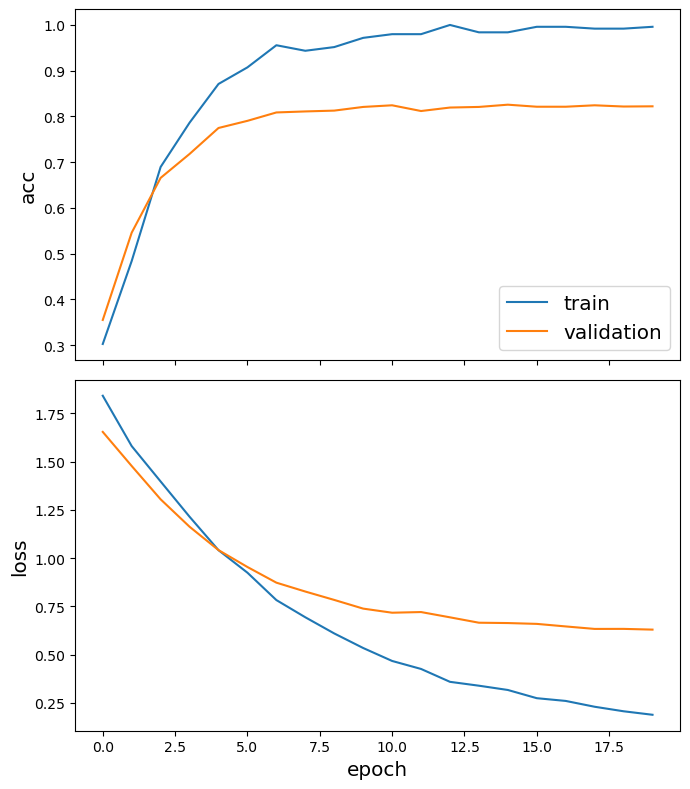

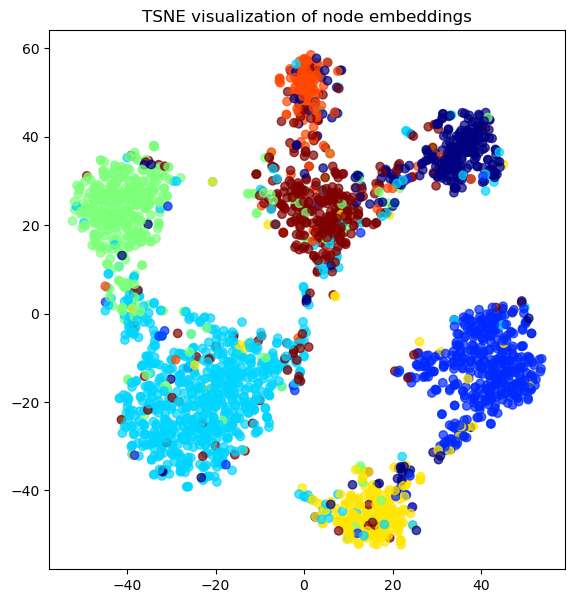

In [110]:
import networkx as nx
import pandas as pd
import os

import stellargraph as sg
from stellargraph.mapper import GraphSAGENodeGenerator
from stellargraph.layer import GraphSAGE

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np




def load_cora_dataset():
    dataset = sg.datasets.Cora()
    display(HTML(dataset.description))
    GS, node_subjects = dataset.load(largest_connected_component_only=True)
    # GS contains the Stellar Graph
    # node_subjects contains the node_features indexed by the node ids
    print(f"The set of classes for nodes:{set(node_subjects)}\n")
    return GS, node_subjects

def train(batch_size = 32,num_samples = [10, 5],lr=0.005,epochs=20,dropout=0.5):
    
    # Load Cora Datasets
    GS, node_subjects = load_cora_dataset()

    # Node features dimension to be used for training
    print(f"Training node input features: {GS.node_features().shape}\n")
    train_subjects, val_subjects = model_selection.train_test_split(
        node_subjects, train_size=0.1, test_size=None, stratify=node_subjects
    )
    
    print(f"Class representation in training data: {dict(Counter(node_subjects))}\n")
    
    
    # Create one hot encoding for node classes
    label_encoder = preprocessing.LabelBinarizer()

    train_y = label_encoder.fit_transform(train_subjects)
    val_y = label_encoder.transform(val_subjects)
    
    # Define GraphSAGENodeGenerator object for tf.keras training 
    generator = GraphSAGENodeGenerator(GS, batch_size, num_samples)
    # Create train and val generator using GraphSAGENodeGenerator object
    train_gen = generator.flow(train_subjects.index, train_y, shuffle=True)
    
    # Create train and val generator using GraphSAGENodeGenerator object
    val_gen = test_gen = generator.flow(val_subjects.index, val_y)
    
    # Define two layer GraphSage Model with 32 units in each layer 
    GS_model = GraphSAGE(
    layer_sizes=[32, 32], generator=generator, bias=True, dropout=0.5,
    )
    
    x_inp, x_out = GS_model.in_out_tensors()
    prediction = layers.Dense(units=train_y.shape[1], activation="softmax")(x_out)
    # The keras model has the GraphSage layers from Stellar followed by the Dense prediction layer of tf.keras.layers 
    model = Model(inputs=x_inp, outputs=prediction)
    print(f"Model Summary...\n")
    print(model.summary())
    
    # Compile the Model
    model.compile(
    optimizer=optimizers.Adam(lr=lr),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
    )
    
    # Train the model
    history = model.fit(
    train_gen, epochs=epochs, validation_data=test_gen, verbose=2, shuffle=False
    )
    
    # Plot the training loss/metric profile
    sg.utils.plot_history(history)
    
    val_metrics = model.evaluate(val_gen)
    print("Val Metrics:\n")
    for name, val in zip(model.metrics_names, val_metrics):
        print("\t{}: {:0.4f}".format(name, val))
    

    # Create embeddings as the output of the Final Graph Sage layer 
    # and see if the embeddings of nodes in similar classes are same
    all_nodes = node_subjects.index
    all_gen = generator.flow(all_nodes)
    emb_model = Model(inputs=x_inp, outputs=x_out)
    emb = emb_model.predict(all_gen)
    print(f"Embeddings shape: {emb.shape}\n")
    plot_embeddings(node_embeddings=emb,node_subjects=node_subjects)
    return model
    
def plot_embeddings(node_embeddings,node_subjects,n_components=2):
    
    transform = TSNE  
    trans = transform(n_components=2)
    node_embeddings_2d = trans.fit_transform(node_embeddings)
    # draw the embedding points, coloring them by the target label (paper subject)
    alpha = 0.7
    label_map = {l: i for i, l in enumerate(np.unique(node_subjects))}
    node_colours = [label_map[target] for target in node_subjects]

    plt.figure(figsize=(7, 7))
    plt.axes().set(aspect="equal")
    plt.scatter(
        node_embeddings_2d[:, 0],
        node_embeddings_2d[:, 1],
        c=node_colours,
        cmap="jet",
        alpha=alpha,
    )
    plt.title("{} visualization of node embeddings".format(transform.__name__))
    plt.show()
    
    
model = train()  